# **Machine learning for Textual and Unstructured Data**

*Coding session 4: Neural Networks for Image Classification and Audio Transcription*

<br>

[Yabra Muvdi](https://yabramuvdi.github.io/) (Barcelona School of Economics, ETH Zurich)

<br>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github//unstructured-data/FRA_IESE_seminar_2023/blob/main/notebooks/4_coding_session.ipynb)



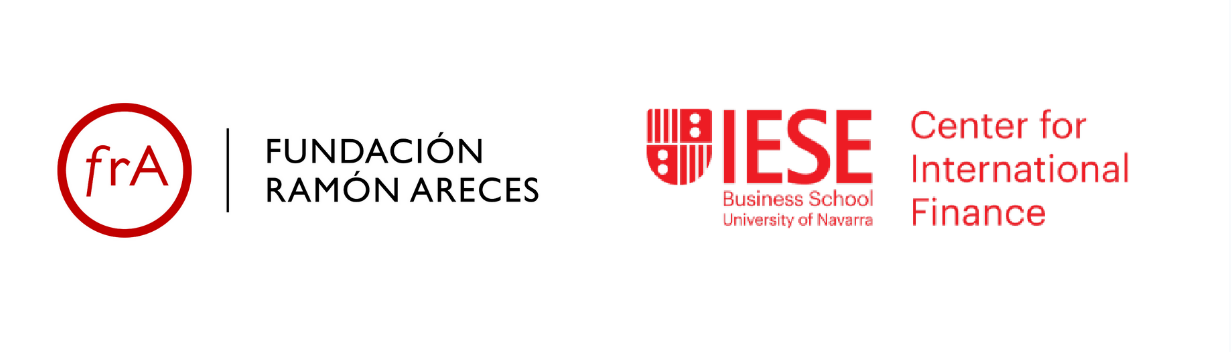

This notebook illustrates how to use and train an image classification model on a particular classification task. Concretely, we will use the [ResNet model](https://huggingface.co/microsoft/resnet-50) to predict the type of land usage (e.g. crop, residential, river) from satellite images.

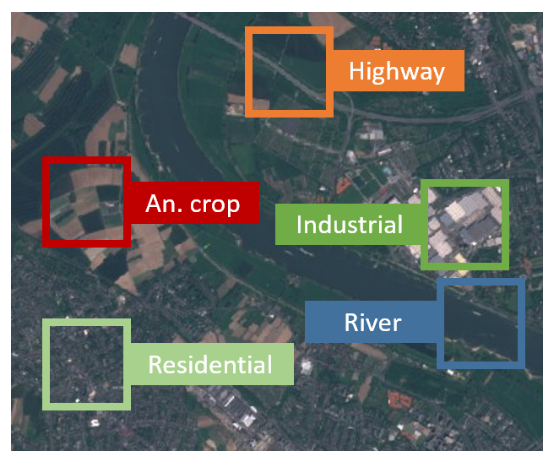

**Tutorials**

- [Image representation in Python](https://www.youtube.com/watch?v=kSqxn6zGE0c)
- [Image classification in HuggingFace](https://huggingface.co/docs/transformers/tasks/image_classification)
- [Visual Transformer finetunning](https://huggingface.co/blog/fine-tune-vit)

**Datset**

- [Paper](https://arxiv.org/pdf/1709.00029.pdf)
- [Sentinel 2 mission](https://sentinel.esa.int/documents/247904/1848117/Sentinel-2_Data_Products_and_Access)
- [Copernicus Data Ecosystem](https://dataspace.copernicus.eu/)

**Methods**

- [Bag of Visual Words](https://www.pinecone.io/learn/bag-of-visual-words/)

- [Visual Transformer](https://arxiv.org/pdf/2010.11929.pdf)

## 0. Setup

In [2]:
%%capture
!pip3 install transformers datasets evaluate accelerate

In [3]:
# basic libraries
import numpy as np
import random
import torch
from IPython.core.display import HTML

# plotting libraries
import matplotlib.pylab as plt

# image processing library
from PIL import ImageDraw, ImageFont, Image

# HuggingFace relevant classes
from transformers import ViTImageProcessor, ViTForImageClassification, ResNetForImageClassification, AutoImageProcessor
from transformers import Trainer, TrainingArguments
from datasets import load_dataset, load_metric
import evaluate

## 1. Load data

This tutorial uses satellite images collected and labeled by [Helber et al., 2019](https://arxiv.org/pdf/1709.00029.pdf). The data (i.e. EuroSAT) is made publicly available through HuggingFace [here](https://huggingface.co/datasets/jonathan-roberts1/EuroSAT). EuroSAT has a total of 27,000 labeled images with 10 different categories of land usage. Original images come from satellites from the [Sentinel-2 mission](https://sentinel.esa.int/web/sentinel/missions/sentinel-2) and focus on Europe.

<br><br>

> Remember you can use HuggingFace's [Datasets Hub](https://huggingface.co/datasets) to explore a wide range of publicly available text and image datasets.

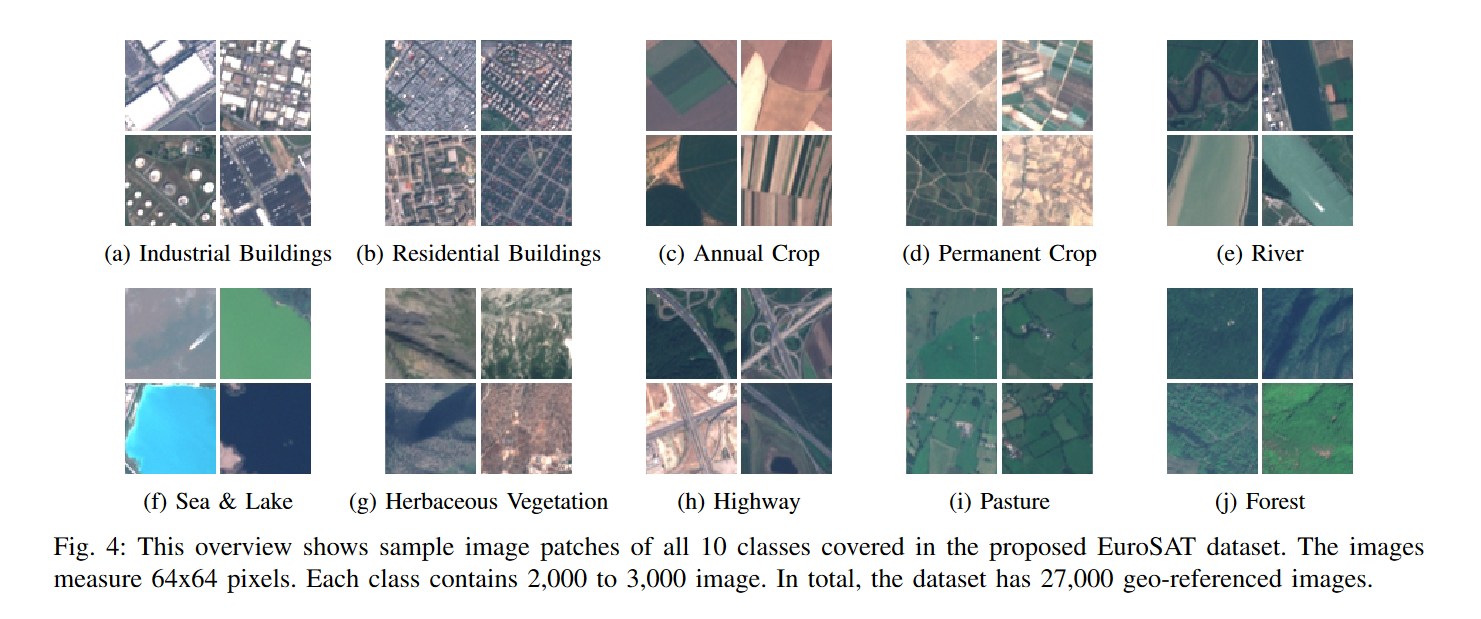

In [4]:
# load land usage dataset directly from HugginFace using only the name
dataset = load_dataset("jonathan-roberts1/EuroSAT")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/27000 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/jonathan-roberts1___parquet/jonathan-roberts1--EuroSAT-f498b53d0f2d55cc/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
# inspect the dataset object
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 27000
    })
})

In [6]:
# see one specific entry:
dataset["train"][10]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=64x64 at 0x7FB2105A2D70>,
 'label': 0}

Label of image:  0 



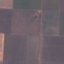

In [7]:
# inspect one of the images and its label
print("Label of image: ", dataset["train"][0]["label"], "\n")
display(dataset["train"][0]["image"])

In [8]:
# get a more detailed description of the labels
labels = dataset['train'].features['label']
for l in labels.names:
    print(f"- {l}")

- annual crop
- forest
- herbaceous vegetation
- highway
- industrial
- pasture
- permanent crop
- residential
- river
- sea or lake


Filter:   0%|          | 0/27000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/27000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/27000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/27000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/27000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/27000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/27000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/27000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/27000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/27000 [00:00<?, ? examples/s]

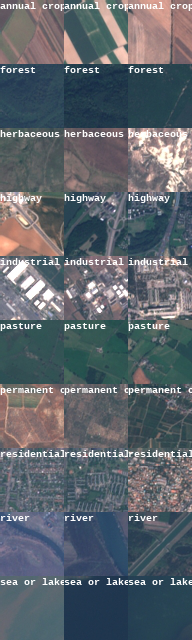

In [9]:
# show examples from all the classes
def show_examples(dataset, seed=1234, examples_per_class=3, size=(64, 64)):

    w, h = size
    labels = dataset['train'].features['label'].names
    grid = Image.new('RGB', size=(examples_per_class * w, len(labels) * h))
    draw = ImageDraw.Draw(grid)
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf", 10)

    for label_id, label in enumerate(labels):

        # Filter the dataset by a single label, shuffle it, and grab a few samples
        ds_slice = dataset['train'].filter(lambda ex: ex['label'] == label_id).shuffle(seed).select(range(examples_per_class))

        # Plot this label's examples along a row
        for i, example in enumerate(ds_slice):
            image = example['image']
            idx = examples_per_class * label_id + i
            box = (idx % examples_per_class * w, idx // examples_per_class * h)
            grid.paste(image.resize(size), box=box)
            draw.text(box, label, (255, 255, 255), font=font)

    return grid


show_examples(dataset, seed=random.randint(0, 1337), examples_per_class=3)

In [10]:
# create a train/test split
dataset = dataset["train"].train_test_split(test_size=0.2)
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 21600
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 5400
    })
})

## 2. Basics of image processing

We will start by briefly understanding how computers work with images. If you want to go further into the topic here are some resources:

- [Udacity tutorial](https://www.youtube.com/watch?v=EXZWHumclx0)

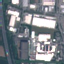

In [11]:
# further inspect one of the images from the training set
image = dataset["train"][0]["image"]
image

In [12]:
# get multiple attributes from the image
image.format, image.size, image.mode

('JPEG', (64, 64), 'RGB')

In [ ]:
# load a manually selected image
image = Image.open("image.jpg")
image

In [ ]:
# get multiple attributes from the image
image.format, image.size, image.mode

('JPEG', (750, 422), 'RGB')

In [ ]:
# get the pixel values from the image
pixels = list(image.getdata())
# look at the RGB values from one pixel
pixels[1001]

(56, 118, 179)

In [ ]:
pixels = np.array(pixels)
pixels.shape

(316500, 3)

In [ ]:
pixels_array = pixels.reshape((422, 750, 3))
pixels_array.shape

(422, 750, 3)

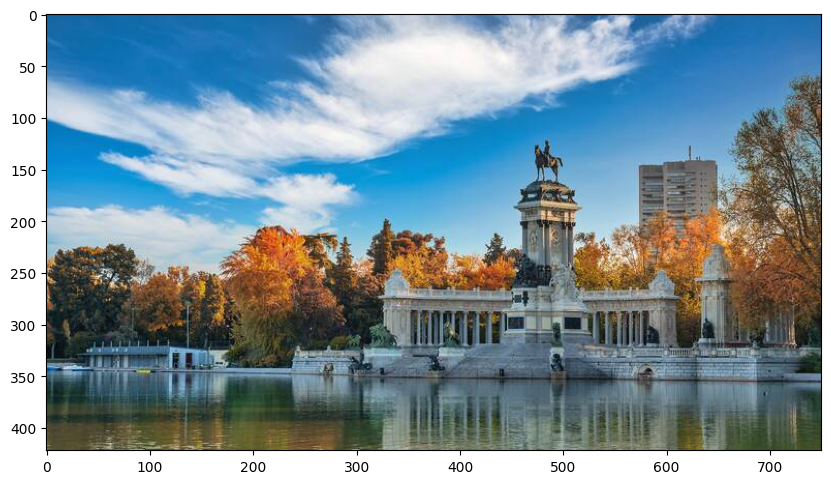

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
ax.imshow(pixels_array)
plt.show()

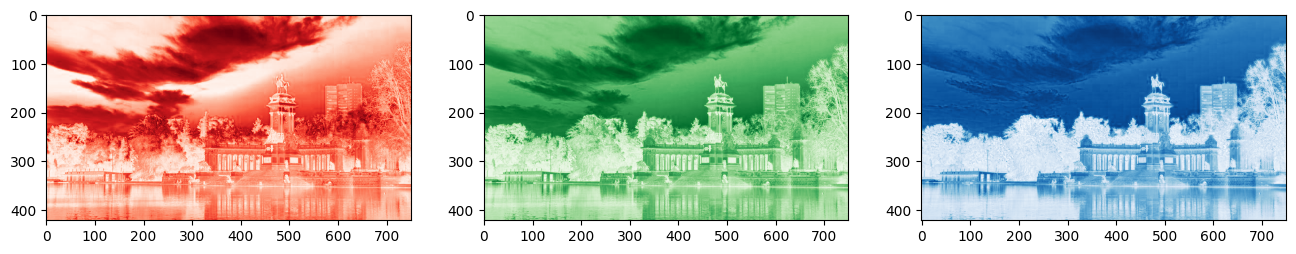

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(16, 12))
axs[0].imshow(pixels_array[:,:,0], cmap="Reds")
axs[1].imshow(pixels_array[:,:,1], cmap="Greens")
axs[2].imshow(pixels_array[:,:,2], cmap="Blues")
plt.show()

In [ ]:
# create an all black image
all_black_pixels = np.zeros(shape=(400, 400, 3))
all_black_pixels.shape

(400, 400, 3)

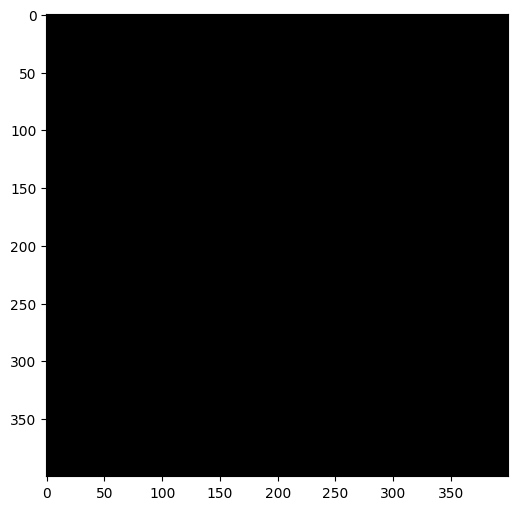

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
ax.imshow(all_black_pixels)
plt.show()

## 3. Loading an image processor

We will now follow a similar pipeline to the LLM finetuning. We start by finding a model for our task in the HuggingFace [Model Hub](https://huggingface.co/models). We will use Microsoft's ```resnet-50``` model.

<br>

In the same spirit as tokenization in the context of text data, images need to be "tokenized" before we use them. Instead of the ```AutoTokenizer()``` we will use the ```AutoImageProcessor()``` class.


In [ ]:
#model_name = 'google/vit-base-patch16-224-in21k'
#model_name = 'google/vit-base-patch16-224'
#feature_extractor = ViTImageProcessor.from_pretrained(model_name, size=(64, 64))

# model_name = 'google/vit-base-patch16-224'
# model = ViTForImageClassification.from_pretrained(model_name)

In [14]:
model_name = 'microsoft/resnet-50'
feature_extractor = AutoImageProcessor.from_pretrained(model_name)
feature_extractor

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


ConvNextImageProcessor {
  "crop_pct": 0.875,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ConvNextImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}

In [19]:
# extract features from a given image
image = dataset["train"][0]["image"]

# look at image
# image

image_features = feature_extractor(image, return_tensors='pt')
image_features

{'pixel_values': tensor([[[[-1.2445, -1.3130, -1.3302,  ...,  0.1768,  0.2282,  0.2624],
          [-1.2617, -1.3130, -1.3302,  ...,  0.1768,  0.2282,  0.2624],
          [-1.2617, -1.3130, -1.3302,  ...,  0.1426,  0.1939,  0.2624],
          ...,
          [-1.2445, -1.2445, -1.2445,  ...,  0.2796,  0.2282,  0.1426],
          [-1.2617, -1.2445, -1.2445,  ...,  0.0741,  0.0056, -0.0801],
          [-1.2788, -1.2788, -1.2788,  ..., -0.1486, -0.2513, -0.3369]],

         [[-0.7052, -0.7927, -0.8277,  ...,  0.2752,  0.3277,  0.3627],
          [-0.7227, -0.8102, -0.8452,  ...,  0.2752,  0.3102,  0.3627],
          [-0.7227, -0.8102, -0.8452,  ...,  0.2402,  0.2927,  0.3452],
          ...,
          [-0.7227, -0.7052, -0.7052,  ...,  0.3627,  0.3452,  0.2752],
          [-0.7227, -0.7052, -0.7052,  ...,  0.1877,  0.1352,  0.0651],
          [-0.7577, -0.7402, -0.7227,  ..., -0.0399, -0.1275, -0.1975]],

         [[-0.4450, -0.4973, -0.4973,  ...,  0.6008,  0.6705,  0.7228],
          [-0

In [16]:
# num_images, num_colors, num_pixels, num_pixels
image_features["pixel_values"].shape

torch.Size([1, 3, 224, 224])

In [17]:
# get all pixel values for the first color (red)
image_features["pixel_values"][0][0].shape

torch.Size([224, 224])

## 4. Loading and using a pre-trained model

In [ ]:
# load pre-trained model
model_name = 'microsoft/resnet-50'
model = ResNetForImageClassification.from_pretrained(model_name)

In [ ]:
# what classes does the model have?
model.num_labels

1000

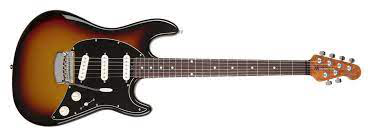

In [ ]:
# load an image
image = Image.open("guitar.jpeg")
image

In [ ]:
# pass the image through the feature extractor
inputs = feature_extractor(image, return_tensors="pt")

with torch.no_grad():
    result = model(**inputs)

In [ ]:
# what is result?
type(result)

transformers.modeling_outputs.ImageClassifierOutputWithNoAttention

In [ ]:
# extract the logits
logits = result.logits
logits.shape

torch.Size([1, 1000])

In [ ]:
# get top labels
top_labels = logits.argsort()[0][-10:]
for i, l in enumerate(reversed(top_labels), 1):
    print(f"{i}. {model.config.id2label[l.item()]}")

1. electric guitar
2. pick, plectrum, plectron
3. hatchet
4. scorpion
5. rhinoceros beetle
6. buckle
7. acoustic guitar
8. hook, claw
9. microphone, mike
10. ski


## 5. Prepare data for finetuning

In [ ]:
def process_example(example):
    inputs = feature_extractor(example['image'], return_tensors='pt')
    inputs['label'] = example['label']
    return inputs

In [ ]:
def transform(example_batch):

    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([x for x in example_batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['labels'] = example_batch['label']
    return inputs

In [ ]:
# apply image processing to the original images
prepared_ds = dataset.with_transform(transform)

In [ ]:
prepared_ds['train'][0:2]

{'pixel_values': tensor([[[[ 0.7762,  0.7762,  0.7419,  ...,  0.2282,  0.2111,  0.1768],
          [ 0.7591,  0.7248,  0.7077,  ...,  0.2282,  0.1939,  0.1426],
          [ 0.7248,  0.6906,  0.6734,  ...,  0.2282,  0.1939,  0.1426],
          ...,
          [-0.1999, -0.2171, -0.2342,  ...,  0.7762,  0.7591,  0.6563],
          [-0.1828, -0.1999, -0.2171,  ...,  0.7077,  0.6906,  0.5878],
          [-0.1314, -0.1486, -0.1657,  ...,  0.6221,  0.5878,  0.4851]],

         [[ 0.6078,  0.5903,  0.5903,  ..., -0.0049, -0.0399, -0.0574],
          [ 0.5728,  0.5378,  0.5378,  ..., -0.0224, -0.0574, -0.0749],
          [ 0.5378,  0.5028,  0.5028,  ..., -0.0224, -0.0574, -0.0924],
          ...,
          [-0.2500, -0.2675, -0.2675,  ...,  0.4678,  0.4678,  0.3978],
          [-0.2325, -0.2500, -0.2500,  ...,  0.4153,  0.4153,  0.3627],
          [-0.1625, -0.1800, -0.1625,  ...,  0.3452,  0.3452,  0.2927]],

         [[ 0.5834,  0.5659,  0.5485,  ...,  0.2173,  0.1999,  0.1651],
          [ 0

## 6. Finetuning

In [ ]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

In [ ]:
metric = evaluate.load("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

In [ ]:
labels = dataset['train'].features['label'].names
labels

['annual crop',
 'forest',
 'herbaceous vegetation',
 'highway',
 'industrial',
 'pasture',
 'permanent crop',
 'residential',
 'river',
 'sea or lake']

In [ ]:
# load pre-trained model
# model = ViTForImageClassification.from_pretrained(
#     model_name_or_path,
#     num_labels=len(labels),
#     id2label={str(i): c for i, c in enumerate(labels)},
#     label2id={c: str(i) for i, c in enumerate(labels)}
# )

# re-load the pre-trained model with relevant parameters
model = ResNetForImageClassification.from_pretrained(
    model_name,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)},
    ignore_mismatched_sizes=True
)

Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([10, 2048]) in the model instantiated
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# define training arguments
training_args = TrainingArguments(
  output_dir="./",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=4,
  fp16=True,
  save_steps=500,
  eval_steps=500,
  logging_steps=100,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
  optim = "adamw_torch"
)

In [ ]:
# initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["test"],
    tokenizer=feature_extractor,
)

In [ ]:
# train!
train_results = trainer.train()
trainer.save_model("./ft_model/")
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Step,Training Loss,Validation Loss,Accuracy
500,0.379700,0.189933,0.944630
1000,0.236600,0.106462,0.964815
1500,0.218100,0.104571,0.966667
2000,0.156800,0.074852,0.976111
2500,0.137300,0.117595,0.963333
3000,0.107000,0.072580,0.975000
3500,0.097300,0.068835,0.978889
4000,0.083400,0.059180,0.980185
4500,0.067800,0.055527,0.981667
5000,0.066500,0.057008,0.982222


***** train metrics *****
  epoch                    =          4.0
  total_flos               = 1709924996GF
  train_loss               =       0.1991
  train_runtime            =   0:29:23.48
  train_samples_per_second =       48.994
  train_steps_per_second   =        3.062


## 7. Use finetuned model

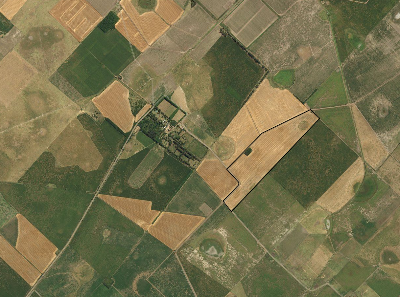

In [ ]:
# get an image from the web
import requests
url = 'https://i.stack.imgur.com/r2G2V.png'
image = Image.open(requests.get(url, stream=True).raw)
image

In [ ]:
# extracting features for the new image
inputs = feature_extractor(images=image, return_tensors="pt")
inputs

{'pixel_values': tensor([[[[ 1.4954,  1.3755,  1.0673,  ..., -0.2171, -0.1999, -0.6281],
          [ 1.2557,  1.0844,  1.2385,  ...,  0.2967, -0.2684, -0.6452],
          [ 0.8618,  1.4269,  0.8447,  ...,  0.5193,  0.2453, -0.1657],
          ...,
          [-0.0116, -0.1486,  0.0398,  ..., -0.1486, -0.0629,  0.0056],
          [-0.3541, -0.1486,  0.2796,  ..., -0.1657,  0.1083,  0.0912],
          [-0.0287, -0.3541,  0.2453,  ..., -0.0458,  0.2453,  0.1597]],

         [[ 0.9580,  0.7654,  0.5028,  ..., -0.0224, -0.0224, -0.2325],
          [ 0.6779,  0.5028,  0.7654,  ...,  0.3102, -0.1275, -0.1800],
          [ 0.2752,  0.8880,  0.3978,  ...,  0.3978,  0.1352,  0.0651],
          ...,
          [ 0.0826, -0.1275, -0.1099,  ..., -0.1450, -0.0399,  0.0126],
          [-0.2500, -0.0924,  0.2052,  ..., -0.1450, -0.0049, -0.0049],
          [-0.0049, -0.3025,  0.2227,  ..., -0.0224,  0.1702,  0.1877]],

         [[ 0.2871,  0.0779, -0.1661,  ..., -0.5670, -0.4973, -0.7761],
          [-0

In [ ]:
# load finetuned model
model_ft = ResNetForImageClassification.from_pretrained('./ft_model/')
outputs = model_ft(**inputs)
outputs

ImageClassifierOutputWithNoAttention(loss=None, logits=tensor([[-4.5593, -8.5016, -3.8244, -7.2756, -1.8142, -3.5342,  6.7940, -4.7785,
         -7.5838, -9.4879]], grad_fn=<AddmmBackward0>), hidden_states=None)

In [ ]:
logits = outputs.logits
probs = torch.nn.functional.softmax(logits, dim=1)
probs = probs.tolist()[0]

# get the position of the max logit
max_idx = np.argmax(probs)
max_label = labels[max_idx]
print(f"Predicted label: {max_label}")

Predicted label: permanent crop


In [ ]:
# list probabilities of all categories
for p, l in zip(probs, labels):
    print(f"{l} with probability: {np.round(p,3)}")

annual crop with probability: 0.0
forest with probability: 0.0
herbaceous vegetation with probability: 0.0
highway with probability: 0.0
industrial with probability: 0.0
pasture with probability: 0.0
permanent crop with probability: 1.0
residential with probability: 0.0
river with probability: 0.0
sea or lake with probability: 0.0


## 8. Audio

- Original [DotCSV notebook](https://colab.research.google.com/drive/1CvvYPAFemIZdSOt9fhN541esSlZR7Ic6?usp=sharing)
- [OpenAI Whisper GitHub]()

In [ ]:
%%capture
!pip3 install git+https://github.com/openai/whisper.git
!pip3 install jiwer ffmpeg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/whisper.git to /tmp/pip-req-build-96ma36_q
  Running command git clone --filter=blob:none --quiet https://github.com/openai/whisper.git /tmp/pip-req-build-96ma36_q
  Resolved https://github.com/openai/whisper.git to commit 248b6cb124225dd263bb9bd32d060b6517e067f8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
audio_path = "./drive/MyDrive/chat_gpt/Sesiones con Consumidor/"

all_files = os.listdir(audio_path)
all_files = [file for file in all_files if "WMA" in file or "mp3" in file or "m4a" in file]
print(f"Files available: {len(all_files)}")
all_files

Files available: 11


['AntiguaCDGSesionConsumidorJovenes19-24nseD.WMA',
 'AntiguaQuetzalSesionConsumidorasconhijos12añoshogar.mp3',
 'AntiguaCDGSesionConsumidorhogaradultosnseD.WMA',
 'AntiguaCDGSesionConsumidrasConhijos12añosnseCC-.mp3',
 'AntiguaQuetzalSesionConsumidorJovenes19-24.WMA',
 'AntiguaCDGMamashijos12-17nseCC-mayo222p.m.WMA',
 'AntiguaCDGSesionConsumidorMamasconhijos12-17nseDmayo229a.m.WMA',
 'AntiguaCDGSesionConsumidorMujeresconhijosmenoresde12añosNSED22May13.00 p.m.m4a',
 'AntiguaQuetzalSesionConsumidorHogaresadultosmayo1916.30p.mparte2.WMA',
 'AntiguaQuetzalHogaresadultosmayo1916.30p.mparte1.WMA',
 'AntiguaQuetzalSesionConsumidorMujeresconhijos12y17años19mayo15p.m.m4a']

In [ ]:
# bash command
!whisper "{file_path}" --task transcribe --model large-v2 --language Spanish --compression_ratio_threshold 1.0 --verbose False --output_dir {output_path} --output_format tsv

In [ ]:
# Iterate over input_files
for file in all_files[0:2]:

    file_path = audio_path + file
    print(f"Processing file: {file_path}\n\n")

    # Run the whisper command with the current input_file and output_file
    #get_ipython().system('whisper "{file_path}" --task transcribe --model small --language Spanish --compression_ratio_threshold 1.0 --verbose False --output_dir {output_path} --output_format tsv')
    get_ipython().system('whisper "{file_path}" --task transcribe --model large-v2 --language Spanish --compression_ratio_threshold 1.0 --verbose True --output_dir ./ --output_format tsv')
